# **ISOLATION FORESTS**

## **Implementacion**

In [52]:
import numpy as np
import matplotlib.pyplot as plt
import csv

from math import e, sqrt, pi, log, inf
from random import randint
from scipy import stats

### **Random Decision Tree**

In [53]:
class Node:
  def __init__(self, parent, X):
    self.parent = parent
    self.X = X

    self.childs = []
    # La i-esima condicion corresponde al i-esimo hijo.
    self.cond = []
    self.leaf = True
    
class RandomDecisionTree:
  def __init__(self, X):
    self.X = X

  def get_values(self, X, a):
    """ Obtenemos los posibles valores de un determinado atributo."""
    n = len(X[0])
    values = []
    for x in X:
      if not x[a] in values: values.append(x[a])
    return values

  def train(self, splits = -1):
    """ Entrenamos el arbol de decisiones segun el numero de divisiones
    y el criterio de division."""

    root = Node(None, self.X)
    queue = [root]
    self.tree = root

    # Usaremos un BFS en vez de DFS.
    while len(queue) > 0:
      node = queue.pop(0)

      # Si no hay mas ejemplos o si alcanzamos el maximo de splits, finalizamos.
      if (len(node.X) == 0) or (splits == 0):
        return
      # Si no, se realizara una division.
      else:
        node.leaf = False
        splits -= 1

        # Seleccionamos un atributo de forma aleatoria.
        atr = randint(0, len(node.X[0])-1)
        # Calculamos la media y la varianza de los posibles valores de dicho atributo.
        values = self.get_values(node.X, atr)
        v_m = sum(v for v in values)/len(values)
        var = sum(v**2 for v in values)/len(values) - v_m**2
        # Seleccionamos aleatoriamente una division de los valores usando una distribucion
        # normal.
        normal = stats.norm(v_m, sqrt(var))
        x_div = normal.rvs(1)[0]
      
        # Particionamos los ejemplos en menor y mayor o igual que la divison obtenida.
        X_M, X_m = [], []
        for i in range(len(node.X)):
          x = node.X[i].copy()
          if node.X[i][atr] < x_div: X_m.append(x)
          else: X_M.append(x)

        # Con esa particion creamos dos nuevos nodos.
        child_m = Node(node, X_m)
        child_M = Node(node, X_M)
        node.childs.append(child_m)
        node.childs.append(child_M)
        node.cond.append((atr, "<", x_div))
        node.cond.append((atr, ">=", x_div))
        queue.append(child_m)
        queue.append(child_M)

  def height(self, x):
    """ Calculamos la altura de un elemento. """

    # Partimos de la raiz.
    node_i = self.tree
    h = 0
    # Mientras no estemos en una hoja
    while not node_i.leaf:
      # En caso contrario, verificamos cual condicion del nodo cumple el patron
      # y lo enviamos al hijo correspondiente.
      cond = False
      h += 1
      for i, c in enumerate(node_i.cond):
        if (c[1] == "<" and x[c[0]] < c[2]) or (c[1] == ">=" and x[c[0]] >= c[2]):
          node_i = node_i.childs[i]
          cond = True
          break
        
    n = len(node_i.X)
    if n > 1: c = 2*(log(n) + 0.5772156649) - 2*(n-1)/n
    else: c = 0
    return h + c

### **Isolation Forest**

In [54]:
class IsolationForest:
  def __init__(self, X):
    self.X = X
    self.forest = []
    # Constante de normalizacion
    n = len(self.X)
    self.c = 2*(log(n-1) + 0.5772156649) - 2*(n-1)/n
    
  def build_forest(self, trees, n_sub_samples):
    # El numero de divisiones de cada arbol estara acotado por el logaritmo en base 2
    # de el numero de muestras que le corresponde a cada arbol.
    splits = int(log(n_sub_samples, 2))
    self.forest = [None for _ in range(trees)]
    for i in range(trees):
      # Creamos una copia de los datos y sacamos algunos aleatoriamente hasta obtener
      # el numero de datos requerido.
      X_i = self.X.copy()
      while len(X_i) > n_sub_samples: X_i.pop(randint(0, len(X_i)-1))
            
      # Creamos el arbol
      self.forest[i] = RandomDecisionTree(X_i.copy())
      self.forest[i].train(splits)
    
  def s(self, x):
    # Calculamos la altura promedio que obtiene el elemento.
    h = sum(self.forest[i].height(x) for i in range(len(self.forest)))/len(self.forest)
    return e**(-h/self.c)

## **Lectura de Datos**

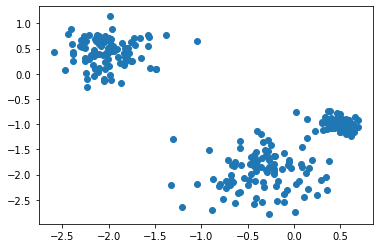

In [55]:
normal1 = stats.norm(-0.4, 0.4)
normal2 = stats.norm(0.5, 0.1)
normal3 = stats.norm(-2, 0.3)
normal4 = stats.norm(2, 0.3)
data = []
for _ in range(100):
  data.append(np.array([normal1.rvs(1)[0], normal1.rvs(1)[0]-1.5]))
  data.append(np.array([normal2.rvs(1)[0], normal2.rvs(1)[0]-1.5]))
  data.append(np.array([normal3.rvs(1)[0], normal4.rvs(1)[0]-1.5]))

plt.plot([d[0] for d in data], [d[1] for d in data], 'o')
plt.show()

## **Resultados**

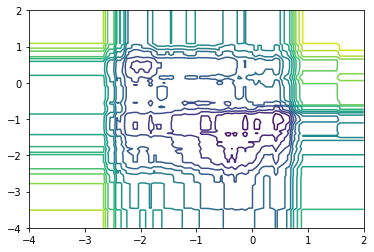

In [56]:
iforest = IsolationForest(data)
iforest.build_forest(50, int(len(data)*0.75))
def p(x): return iforest.s(x)

x = y = np.linspace(-4, 2, 100)
X, Y = np.meshgrid(x,y)

Z = [[0 for _ in range(len(X[0]))] for _ in range(len(X))]
for i in range(len(X)):
    for j in range(len(X[0])):
        Z[i][j] = p(np.array([X[i][j], Y[i][j]]))
        
plt.contour(X, Y, Z, 20)
plt.show()